In [1]:
import os
import pickle
import random
import math
import time
import glob

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

In [2]:
ROLLOUT_PATH='/home/puzi/RL/my_homework/hw1/rollouts'
MAX_ITER=100000
MAX_EPOCHS=100
NUM_EPOCHS_VAL=1
BATCH_SIZE=512
HIDDEN_UNITS1=128
HIDDEN_UNITS2=128
BASE_LR=0.01
NUM_LR_REDUCTIONS=3
RENDER=True
L2_REG_FACTOR=0.05
VERBOSE=False

# Constants

In [3]:
envs=glob.glob(os.path.join(ROLLOUT_PATH,'*pkl'))
envs=[os.path.basename(s)[:-12] for s in envs]
print (envs)

['Ant-v1', 'Reacher-v1', 'Hopper-v1', 'Humanoid-v1', 'HalfCheetah-v1', 'Walker2d-v1']


In [4]:
ENV_NAME=envs[-1]
fi=open(os.path.join(ROLLOUT_PATH,ENV_NAME+'_rollout.pkl'),'r')
data=pickle.load(fi)
fi.close()

obs=data['observations']
act=data['actions']
rewards=data['returns']

#random.shuffle(obs)
#random.shuffle(act)

In [5]:
act=act.reshape((act.shape[0],act.shape[-1]))
print (obs.shape)
print (act.shape)


input_size=obs.shape[-1]
output_size=act.shape[-1]

(50000, 17)
(50000, 6)


In [6]:
x_train, x_val, y_train, y_val = train_test_split(obs, act, test_size=0.15)#, random_state=3)

In [7]:
print x_train.shape
print y_train.shape
print x_val.shape
print y_val.shape

(42500, 17)
(42500, 6)
(7500, 17)
(7500, 6)


In [8]:
ITER_PER_EPOCH=x_train.shape[0]/BATCH_SIZE+1

## Normalize Data

In [9]:
mean=np.mean(x_train, axis=0)
stdev=np.std(x_train, axis=0)

x_train-=mean
x_train/=stdev

x_val-=mean
x_val/=stdev


## Train Net

x = tf.placeholder(tf.float32, [None, input_size])
y_ = tf.placeholder(tf.float32, shape=[None, output_size])


HIDDEN_UNITS1=128

with tf.name_scope('hidden1'):
    weights = tf.Variable(tf.truncated_normal([input_size, HIDDEN_UNITS1],stddev=1.0 / math.sqrt(float(input_size))),name='weights')
    #weights = tf.Variable(tf.truncated_normal([input_size, HIDDEN_UNITS1],stddev=1.0),name='weights')
    biases = tf.Variable(tf.zeros([HIDDEN_UNITS1])+0.1,name='biases')
    hidden1_reg=tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)

    hidden1 = tf.nn.relu(tf.matmul(x, weights) + biases)


with tf.name_scope('regress'):
    weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS1, output_size],stddev=1.0 / math.sqrt(float(output_size))),name='weights')
    #weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS2, output_size],stddev=1.0),name='weights')
    biases = tf.Variable(tf.zeros([output_size])+0.1,name='biases')
    regress_reg=tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)

    output = tf.nn.tanh(tf.matmul(hidden1, weights) + biases)
    pred_loss=tf.losses.mean_squared_error(y_,output)

loss=pred_loss+L2_REG_FACTOR*(hidden1_reg+regress_reg)



global_step = tf.Variable(0, name='global_step', trainable=False)
#lr=tf.Variable(BASE_LR,name='lr',trainable=False)
lr=tf.train.exponential_decay(BASE_LR,global_step, ITER_PER_EPOCH*(MAX_EPOCHS/NUM_LR_REDUCTIONS),0.01,staircase=True)
optimizer = tf.train.GradientDescentOptimizer(lr)
#optimizer=tf.train.MomentumOptimizer(learning_rate=lr,momentum=0.005,use_nesterov=True)

train_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
epoch_loss=[]
epoch1_loss=[]
val_dist=[]
print "Training Net"
for epoch in range(MAX_EPOCHS):
    start=time.time()
    if epoch>MAX_EPOCHS/NUM_LR_REDUCTIONS*2+10:
        if float(val_dist[-10]-val_dist[-1])/val_dist[-1]<0.01:
            print "No improvemet in Val accuracy over last 10 epochs, terminating"
            break
    #if epoch>0 and epoch%(MAX_EPOCHS/NUM_LR_REDUCTIONS)==0:
        #lr=lr/float(100)
    for iter in range(ITER_PER_EPOCH):
        batch_x=x_train[:BATCH_SIZE,:]
        batch_y=y_train[:BATCH_SIZE,:]
        x_train=np.append(x_train[BATCH_SIZE:,:],x_train[:BATCH_SIZE,:],axis=0)
        y_train=np.append(y_train[BATCH_SIZE:,:],y_train[:BATCH_SIZE,:],axis=0)
        _,p_loss, loss_value = sess.run([train_op, pred_loss,loss],feed_dict={x:batch_x,y_:batch_y})
        if epoch==0:
            epoch1_loss.append(loss_value)
            if VERBOSE:
                print "Epoch=0, Iteration=",str(iter), " loss=",str(loss_value)
    epoch_loss.append(loss_value)
    print "Finished running epoch=",str(epoch), "loss=",str(loss_value),"epoc duration=",str(time.time()-start), "seconds"
    if epoch%NUM_EPOCHS_VAL==0:
        print "Evaluating validation set"
        #pred=sess.run(output,feed_dict={x:x_val})
        #pred=output
        dist=tf.losses.mean_squared_error(y_val,output)
        p,d=sess.run([output, dist],feed_dict={x:x_val})
        val_dist.append(d)
        print "Total error=", str(d)  
    
        

In [10]:
x = tf.placeholder(tf.float32, [None, input_size])
y_ = tf.placeholder(tf.float32, shape=[None, output_size])


HIDDEN_UNITS1=128
HIDDEN_UNITS2=64

with tf.name_scope('hidden1'):
    weights = tf.Variable(tf.truncated_normal([input_size, HIDDEN_UNITS1],stddev=1.0 / math.sqrt(float(input_size))),name='weights')
    #weights = tf.Variable(tf.truncated_normal([input_size, HIDDEN_UNITS1],stddev=1.0),name='weights')
    biases = tf.Variable(tf.zeros([HIDDEN_UNITS1])+0.1,name='biases')
    hidden1_reg=tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)

    hidden1 = tf.nn.relu(tf.matmul(x, weights) + biases)
    tf.summary.histogram('hidden1',hidden1)

with tf.name_scope('hidden2'):
    weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS1, HIDDEN_UNITS2],stddev=1.0 / math.sqrt(float(HIDDEN_UNITS1))),name='weights')
    #weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS1, HIDDEN_UNITS2],stddev=1.0),name='weights')
    biases = tf.Variable(tf.zeros([HIDDEN_UNITS2])+0.1,name='biases')
    hidden2_reg=tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)

    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    tf.summary.histogram('hidden2',hidden2)

with tf.name_scope('regress'):
    weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS2, output_size],stddev=1.0 / math.sqrt(float(output_size))),name='weights')
    #weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS2, output_size],stddev=1.0),name='weights')
    biases = tf.Variable(tf.zeros([output_size])+0.1,name='biases')
    regress_reg=tf.nn.l2_loss(weights)+tf.nn.l2_loss(biases)

    output = tf.nn.tanh(tf.matmul(hidden2, weights) + biases)
    pred_loss=tf.losses.mean_squared_error(y_,output)
    tf.summary.histogram('output',output)
    tf.summary.scalar('pred_loss',pred_loss)

loss=pred_loss+L2_REG_FACTOR*(hidden1_reg+hidden2_reg+regress_reg)

global_step = tf.Variable(0, name='global_step', trainable=False)
#lr=tf.train.exponential_decay(BASE_LR,global_step, ITER_PER_EPOCH*(MAX_EPOCHS/NUM_LR_REDUCTIONS),0.01,staircase=True)
lr=tf.constant(0.01)
optimizer = tf.train.GradientDescentOptimizer(lr)
#optimizer=tf.train.MomentumOptimizer(learning_rate=lr,momentum=0.005,use_nesterov=True)


train_op = optimizer.minimize(loss, global_step=global_step)
tf.summary.scalar('lr',lr)
tf.summary.scalar('loss',loss)



sess = tf.Session()


init = tf.global_variables_initializer()
merged=tf.summary.merge_all()


sess.run(init)

writer=tf.summary.FileWriter('./reports',sess.graph)
epoch_loss=[]
epoch1_loss=[]
val_dist=[]
print "Training Net"
for epoch in range(MAX_EPOCHS):
    start=time.time()
    if epoch>MAX_EPOCHS/NUM_LR_REDUCTIONS*2+10:
        if float(val_dist[-10]-val_dist[-1])/val_dist[-1]<0.01:
            print "No improvemet in Val accuracy over last 10 epochs, terminating"
            break
    #if epoch>0 and epoch%(MAX_EPOCHS/NUM_LR_REDUCTIONS)==0:
        #lr=lr/float(100)
    for iter in range(ITER_PER_EPOCH):
        batch_x=x_train[:BATCH_SIZE,:]
        batch_y=y_train[:BATCH_SIZE,:]
        x_train=np.append(x_train[BATCH_SIZE:,:],x_train[:BATCH_SIZE,:],axis=0)
        y_train=np.append(y_train[BATCH_SIZE:,:],y_train[:BATCH_SIZE,:],axis=0)
        summary,_,p_loss, loss_value = sess.run([merged,train_op, pred_loss,loss],feed_dict={x:batch_x,y_:batch_y})
        writer.add_summary(summary,iter)
        if epoch==0:
            epoch1_loss.append(loss_value)
            if VERBOSE:
                print "Epoch=0, Iteration=",str(iter), " loss=",str(loss_value)
    epoch_loss.append(loss_value)
    print "Finished running epoch=",str(epoch), "loss=",str(loss_value),"epoc duration=",str(time.time()-start), "seconds"
    if epoch%NUM_EPOCHS_VAL==0:
        print "Evaluating validation set"
        #pred=sess.run(output,feed_dict={x:x_val})
        #pred=output
        dist=tf.losses.mean_squared_error(y_val,output)
        p,d=sess.run([output, dist],feed_dict={x:x_val})
        val_dist.append(d)
        print "Total error=", str(d)  
    
        

Training Net
Finished running epoch= 0 loss= 5.168 epoc duration= 1.04926395416 seconds
Evaluating validation set
Total error= 0.526072
Finished running epoch= 1 loss= 4.69599 epoc duration= 0.946886062622 seconds
Evaluating validation set
Total error= 0.458621
Finished running epoch= 2 loss= 4.35603 epoc duration= 0.934782981873 seconds
Evaluating validation set
Total error= 0.432163
Finished running epoch= 3 loss= 4.04491 epoc duration= 0.945519924164 seconds
Evaluating validation set
Total error= 0.420124
Finished running epoch= 4 loss= 3.75078 epoc duration= 0.972482919693 seconds
Evaluating validation set
Total error= 0.412848
Finished running epoch= 5 loss= 3.46871 epoc duration= 0.927798986435 seconds
Evaluating validation set
Total error= 0.408253
Finished running epoch= 6 loss= 3.2522 epoc duration= 0.955096960068 seconds
Evaluating validation set
Total error= 0.405837
Finished running epoch= 7 loss= 3.01045 epoc duration= 0.934962034225 seconds
Evaluating validation set
Total

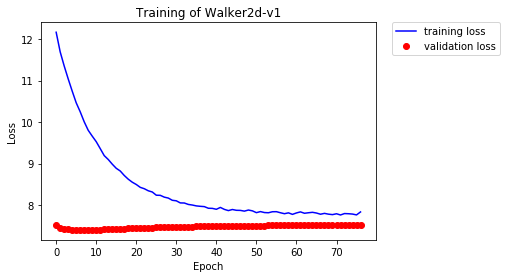

In [11]:
#loss_chart=np.concatenate((epoch1_loss[0],val_dist))
train_loss=plt.plot(epoch1_loss[0]+epoch_loss,'b-')
plt.setp(train_loss, 'label','training loss')
val_loss=plt.plot(epoch1_loss[0]+val_dist,'ro')
plt.setp(val_loss, 'label','validation loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training of '+ENV_NAME)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Test Model

In [ ]:
RENDER=False #Comment this line to see env rendering
test_rewards=[]
env=gym.make(ENV_NAME)
max_steps=env.spec.timestep_limit
for i in range(len(rewards)):
    print "Running rollout ", str(i)
    obs = env.reset()
    obs-=mean
    obs/=stdev
    reward=0
    steps=0
    done = False
    
    while not done:
        action=sess.run(output,feed_dict={x:obs[None,:]})
        #print action
        obs,r,done,_=env.step(action)
        obs-=mean
        obs/=stdev
        reward+=r
        steps+=1
        if steps % 100 == 0: 
            print("%i/%i"%(steps, max_steps))
        if RENDER:
            env.render()
        if steps>max_steps:
            break
    print str(steps),str(reward)
    test_rewards.append(reward)
    
    

In [ ]:
sess.close()

In [ ]:
bbox=plt.boxplot([rewards,test_rewards])
plt.show()

# Dagger

In [ ]:
import tf_util
import load_policy

D_INIT_SIZE=40000
NUM_DAgger_ITERS=10
NUM_OBS_PER_ITER=10000

D_x=x_train[:D_INIT_SIZE,:]
D_y=y_train[:D_INIT_SIZE,:]

policy_fn = load_policy.load_policy(os.path.join('./experts/',ENV_NAME+'.pkl'))




In [ ]:
sess.run(init)
epoch_loss=[]
val_dist=[]
print "Training Net"
for i in range(NUM_DAgger_ITERS):
    print "Running DAgger iteration #:", str(i)
    #Train net on D
    for epoch in range(MAX_EPOCHS):
        start=time.time()
        for iter in range(ITER_PER_EPOCH):
            batch_x=D_x[:BATCH_SIZE,:]
            batch_y=D_y[:BATCH_SIZE,:]
            D_x=np.append(D_x[BATCH_SIZE:,:],D_x[:BATCH_SIZE,:],axis=0)
            D_y=np.append(D_y[BATCH_SIZE:,:],D_y[:BATCH_SIZE,:],axis=0)
            _, loss_value = sess.run([train_op, loss],feed_dict={x:batch_x,y_:batch_y})
        epoch_loss.append(loss_value)
        print "Finished running epoch=",str(epoch), "loss=",str(loss_value),"epoc duration=",str(time.time()-start), "seconds"
        if epoch%NUM_EPOCHS_VAL==0:
            print "Evaluating validation set"
            #pred=sess.run(output,feed_dict={x:x_val})
            #pred=output
            dist=tf.losses.mean_squared_error(y_val,output)
            p,d=sess.run([output, dist],feed_dict={x:x_val})
            val_dist.append(d)
            print "Total error=", str(d)
    
    #Generate new observations
    new_obs=[]
    while len(new_obs)<NUM_OBS_PER_ITER:
        obs = env.reset()
        obs-=mean
        obs/=stdev
        reward=0
        steps=0
        done = False

        while not done:
            action=sess.run(output,feed_dict={x:obs[None,:]})
            #print action
            obs,r,done,_=env.step(action)
            obs-=mean
            obs/=stdev
            reward+=r
            steps+=1
            if steps % 100 == 0: 
                print("%i/%i"%(steps, max_steps))
            if RENDER:
                env.render()
            if steps>max_steps:
                break
    